<a href="https://colab.research.google.com/github/y2236li/Kiwi-Reasearch/blob/master/1D_Climber_Post_Trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [0]:
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

In [0]:
def calAccuracy(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)
  return y


def calReward(x):
  return accuracy_lookuptb[x]

def detect(detect_range, x):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  return [calReward(pos) if pos in x_range else 0 for pos in x_detect_range]


def step(cur_state, action):
  next_x = max(min(max(x_range), cur_state[-1] + action), 1)
  next_state = detect(detect_range, next_x) + [next_x]
  reward = calReward(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_mem[index] = reward


def detectTest(detect_range, x):
  """
  return the accuracy of detecting area around the x
  """
  x_detect_range = np.array(detect_range) + x
  
  return [calAccuracyTest(pos) if pos in x_range else 0 for pos in x_detect_range]

def calAccuracyTest(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train_test, Y_train_test)
  Y_pred = pls2.predict(X_test_test)
  y = r2_score(Y_pred, Y_test_test)
  return y

def calRewardTest(x):
  return accuracy_lookuptb_test[x]


def detectTest(detect_range, x):
  """
  return the accuracy of detecting area around the x
  """
  x_detect_range = np.array(detect_range, dtype=np.int64) + int(x)
  return [calAccuracyTest(pos) if pos in x_range else 0 for pos in x_detect_range]



def stepTest(cur_state, action):
  next_x = int(max(min(max(x_range), cur_state[-1] + action), 1))
  next_state = detectTest(detect_range, next_x) + [next_x]
  reward = calAccuracyTest(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_mem[index] = reward



## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

x_range = range(1, 200)

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

detect_range = [-3, -1, 0, 1, 3] # also input dim
step_options = [-8, -3, -1, 0, 1, 3, 8] # also action space

lr = 0.01 # also alpha
one_game_steps = 300


gamma = 0.8


#memory variables
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

## Check if the max change if different data

In [0]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
for i in range(30):
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train = X[train_indices]
  X_test = X[test_indices]
  Y_train = Y[train_indices]
  Y_test = Y[test_indices]
  accuracy_list = []
  for x in x_range:
    accuracy_list.append(calAccuracy(x))
  plt.plot(accuracy_list)
  plt.show()
  print(np.argmax(accuracy_list))

KeyboardInterrupt: ignored

## Find a accuracy map with relatively wide range of accuracy

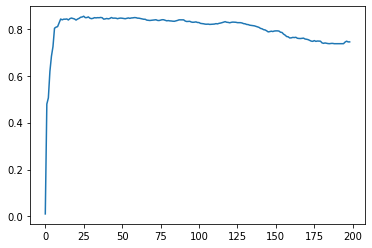

25


In [7]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracy(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

## Create a scaler for param

In [0]:
# data = [[*([0]*len(detect_range)), 1], [*([1]*len(detect_range)), max(x_range)]]
# scaler = MinMaxScaler()
# scaler.fit(data)
# scaler.data_range_.shape

## Game Initialization

In [0]:
mem_size = one_game_steps * 4
batch_size = int(one_game_steps /64) * 64
assert batch_size <= mem_size
random_walk_period = batch_size

accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

random_walk_period = batch_size
scaler_state = MinMaxScaler()
scaler_state.fit([detect(detect_range, x) + [x] for x in x_range if np.prod(detect(detect_range, x)) > 0])

x = 190
detection = detect(detect_range, x)
cur_nor_state = scaler_state.transform([detection + [x]])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state

## Create a Fully Connected Neural Network for Q Learning

In [0]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [14]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.106.188.130:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.106.188.130:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15487999712974801971)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13217902821873263545)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6609804529583727763)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 255925553272597873)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/d

## Convert to TPU model

In [0]:
def makeModel():
    fc2_dims = 200
    model = tf.keras.Sequential(
      [
       tf.keras.layers.Dense(200, input_shape=(np.array(cur_state).shape[0],)),
       tf.keras.layers.Activation('relu'),
       tf.keras.layers.Dense(fc2_dims),
       tf.keras.layers.Activation('relu'),
       tf.keras.layers.Dense(len(step_options))
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='mse')
                  # metrics=['accuracy'])
    return model

# def makeModel():
#   fc2_dims = 200

#   q_model = tf.keras.Sequential([
#           tf.keras.layers.Dense(200, input_shape=(np.array(cur_state).shape[0],)),
#           tf.keras.layers.Activation('relu'),
#           tf.keras.layers.Dense(fc2_dims),
#           tf.keras.layers.Activation('relu'),
#           tf.keras.layers.Dense(len(step_options))
#       ])

#   q_model.compile(optimizer=Adam(), loss='mse')
#   return q_model

with strategy.scope():
    q_model = makeModel()

## Main

In [55]:
%%time

mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

reward_his = []

n_games = 10
gamma = 0.5

epsilon = 0.1
epsilon_dec = 0.8

for _ in tqdm(range(n_games)):
  # cur_state = init_state
  # cur_nor_state = init_nor_state
  for step_ctr in range(one_game_steps):
    
  # predict action
    epsilon *= epsilon_dec
    if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
      action = np.random.choice(step_options)
    else:
      # once random walk were done, the state in memory will be normalized

      indices = np.random.choice(len(state_mem), batch_size, replace=False)

      batch_states = np.array(list(state_mem.values()))[indices]
      batch_next_states = np.array(list(next_state_mem.values()))[indices]
      batch_actions = np.array(list(onehot_action_mem.values()))[indices]
      batch_rewards = np.array(list(reward_mem.values()))[indices]
      
      
      # batch_states = batch_states.astype(tf.int64)
      batch_states_tf = tf.convert_to_tensor(batch_states, dtype=tf.float32)
      batch_states_tf =  tf.cast(batch_states_tf, tf.float32)
      print("HERE!", batch_states_tf)
      # q_matrix = 
      q_model.predict(batch_states_tf)
      print("HERE22!")
      # batch_next_states = batch_next_states.astype(np.int64)
      # q_next = q_model.predict(batch_next_states)

      # actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
      # batch_indices = np.arange(batch_size, dtype=np.int64)

      # q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)

      # # q_matrix = q_matrix.astype(np.int64)
      # q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

      # action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
    
    next_state, reward = step(cur_state, action)
    next_nor_state = scaler_state.transform([next_state])[0]
    
    writeMem(cur_nor_state, next_nor_state, action, reward)
    reward_his.append(reward)

    cur_state = next_state
    cur_nor_state = next_nor_state

    mem_ctr += 1

  0%|          | 0/10 [00:00<?, ?it/s]

HERE! Tensor("Const_21:0", shape=(256, 6), dtype=float32)


InvalidArgumentError: ignored

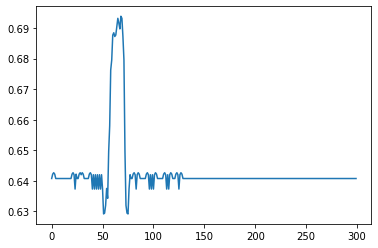

In [0]:
plt.plot(reward_his[one_game_steps*n:one_game_steps*(n+1)]) #mem_size = 40

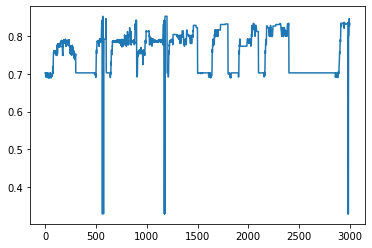

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 300

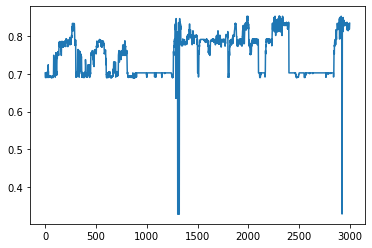

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 with improper nomalization func

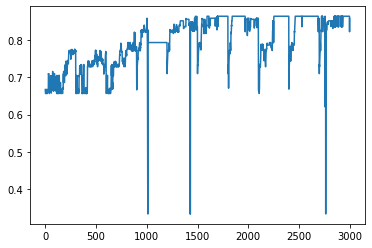

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.5 with proper nomalization func trial 1

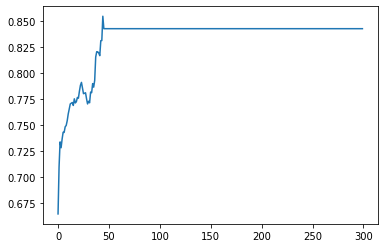

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

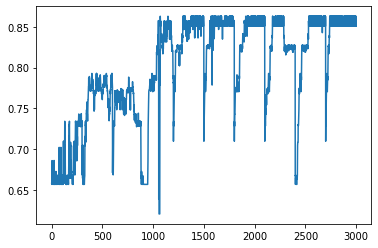

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.5 with proper nomalization func trial 2

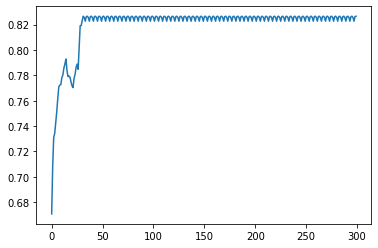

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

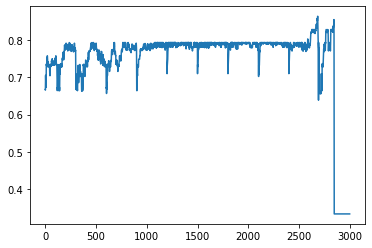

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.8 with proper nomalization func

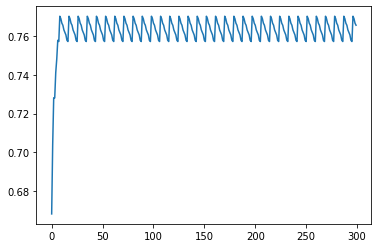

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

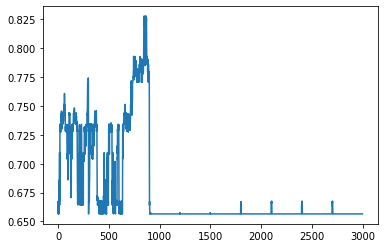

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 1 with proper nomalization func

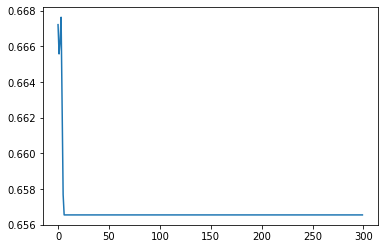

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

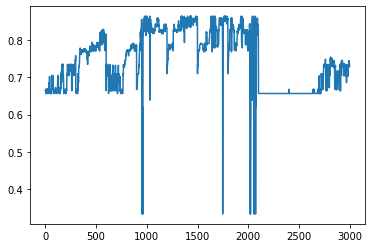

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.2 with proper nomalization func

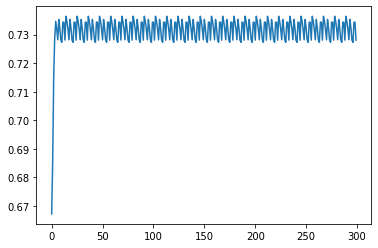

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

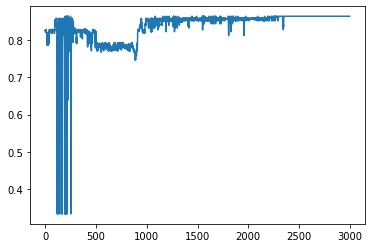

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.5 with proper nomalization func, not reset position at each game

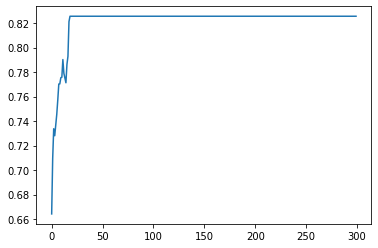

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

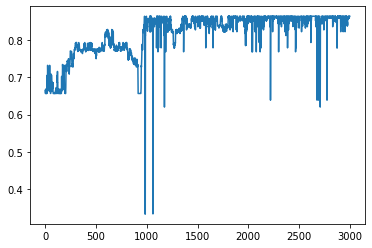

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.5 with proper nomalization func, not reset position at each game, add epsilon = .2

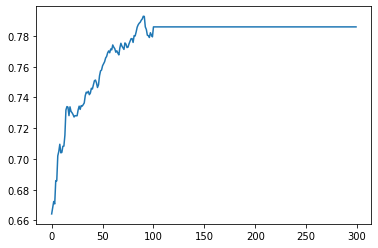

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

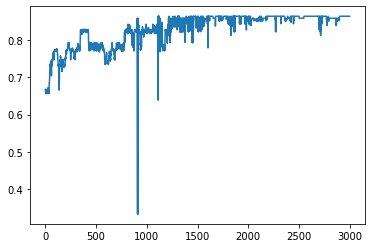

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.5 with proper nomalization func, not reset position at each game, add epsilon = .2, epsilon_dec = 0.8

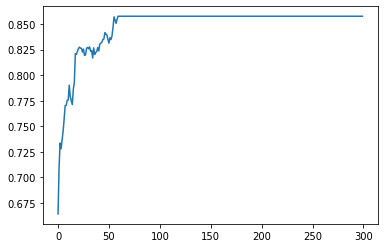

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
# prediction

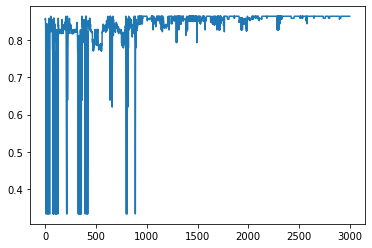

In [0]:
plt.plot(reward_his) #mem_size = 1200, batch_size = 900 gamma = 0.5 with proper nomalization func, not reset position at each game, add epsilon = .2, epsilon_dec = 0.8, epoch = 20

[0.8215909309092564, 0.8427932810725868, 0.8629841578001547, 0.8576737454028565, 0.8507146092130624, 11.0]


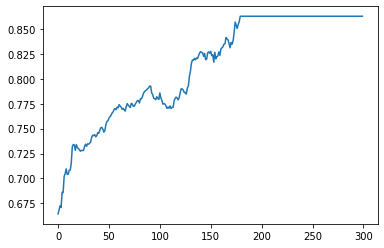

In [0]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = step(cur_state, action)
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
print(cur_state)
# prediction

## Test by Changing Test Set

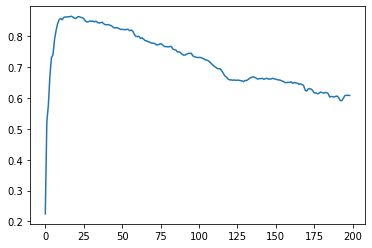

17


In [0]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracyTest(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

100%|██████████| 180/180 [00:12<00:00, 14.91it/s]


[0.8540751543832334, 0.8536528226092378, 0.8611074600565263, 0.8625967828623834, 0.863524750271403, 13]
[0.8625967828623834, 0.863524750271403, 0.8637224052589498, 0.8650366539645623, 0.8584342941618182, 17]


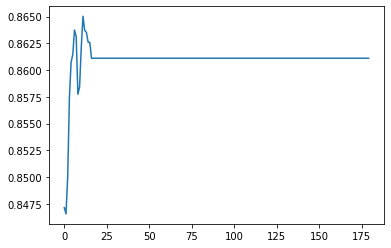

In [0]:
x = 30
detection = detectTest(detect_range, x)
cur_nor_state = scaler_state.transform([detection + [x]])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state
prediction = []
cur_state = init_state
max_state = cur_state
for step_ctr in tqdm(range(180)):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = stepTest(cur_state, action)
  if reward > max_state[3]:
    max_state = next_state
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
print(cur_state)
print(max_state)

## Train same agent under different accuracy map

In [0]:
mem_size = one_game_steps * n_games * 4
batch_size = one_game_steps * n_games
assert batch_size <= mem_size
random_walk_period = batch_size

accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

random_walk_period = batch_size
scaler_state = MinMaxScaler()
scaler_state.fit([detect(detect_range, x) + [x] for x in x_range if np.prod(detect(detect_range, x)) > 0])

x = 190
detection = detect(detect_range, x)
cur_nor_state = scaler_state.transform([detection + [x]])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state


fc2_dims = 200
# fc3_dims = 200
q_model = Sequential([
        Dense(200, input_shape=(cur_state.shape[0],)),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        # Dense(fc3_dims),
        # Activation('relu'),
        Dense(len(step_options))
    ])

q_model.compile(optimizer=Adam(lr=lr), loss='mse')




  0%|          | 0/20 [00:00<?, ?it/s]

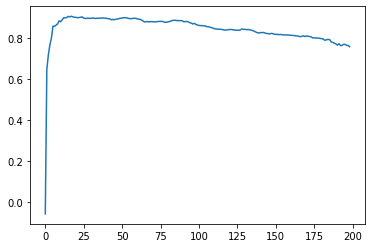

17





  5%|▌         | 1/20 [00:13<04:17, 13.54s/it]

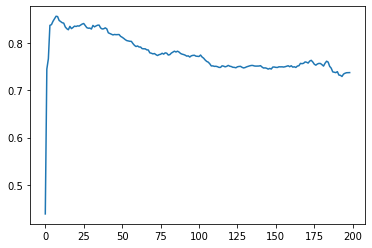

7





 10%|█         | 2/20 [11:43<1:04:55, 216.44s/it]

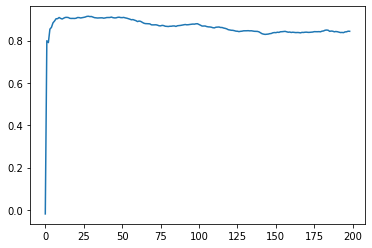

28





 15%|█▌        | 3/20 [23:25<1:42:36, 362.13s/it]

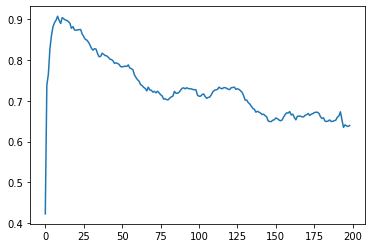

8





 20%|██        | 4/20 [35:22<2:04:57, 468.59s/it]

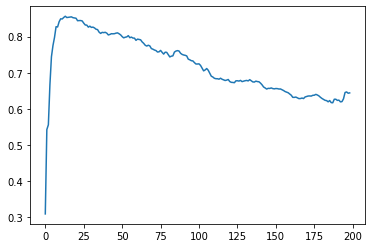

13





 25%|██▌       | 5/20 [47:27<2:16:21, 545.41s/it]

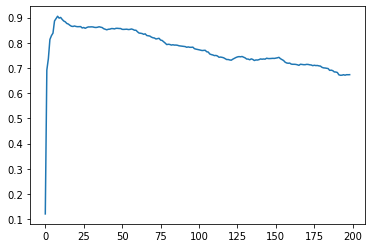

8





 30%|███       | 6/20 [59:34<2:19:59, 599.97s/it]

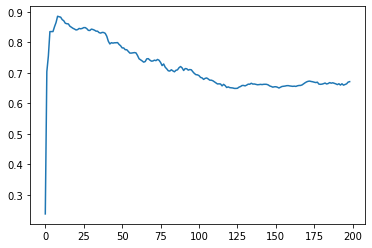

8





 35%|███▌      | 7/20 [1:11:43<2:18:23, 638.74s/it]

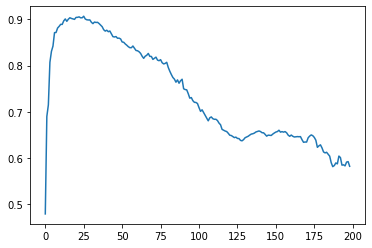

25





 40%|████      | 8/20 [1:23:51<2:13:07, 665.62s/it]

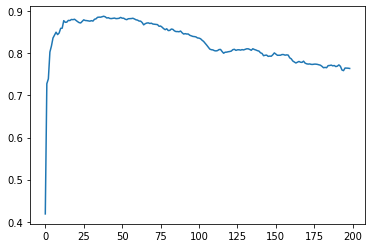

38





 45%|████▌     | 9/20 [1:35:59<2:05:27, 684.29s/it]

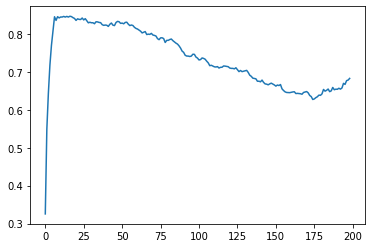

16





 50%|█████     | 10/20 [1:48:05<1:56:06, 696.68s/it]

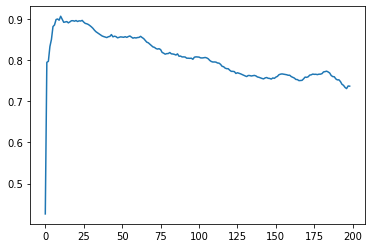

10





 55%|█████▌    | 11/20 [2:00:15<1:46:01, 706.84s/it]

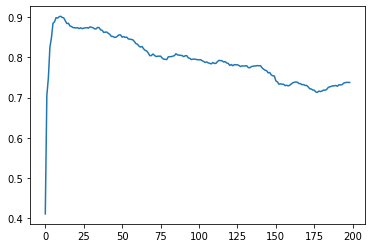

10





 60%|██████    | 12/20 [2:12:24<1:35:07, 713.40s/it]

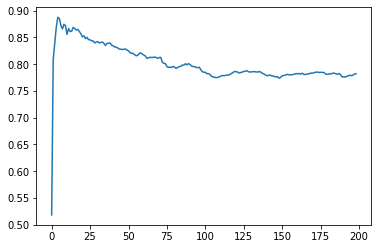

4





 65%|██████▌   | 13/20 [2:24:32<1:23:43, 717.62s/it]

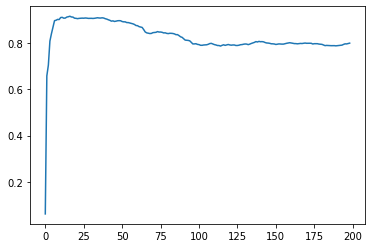

16





 70%|███████   | 14/20 [2:36:40<1:12:04, 720.70s/it]

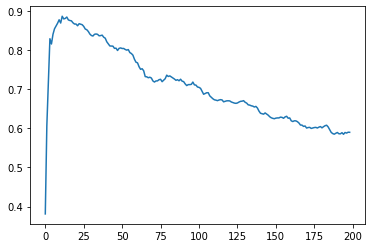

11





 75%|███████▌  | 15/20 [2:48:48<1:00:14, 722.98s/it]

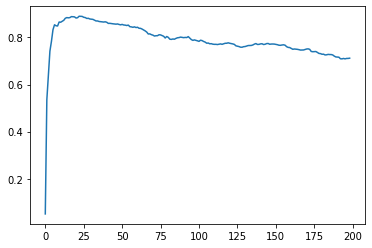

22





 80%|████████  | 16/20 [3:00:59<48:22, 725.53s/it]  

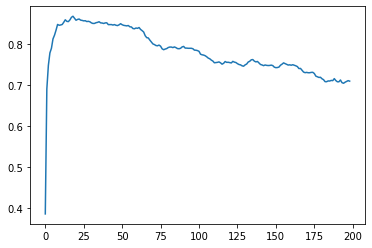

18





 85%|████████▌ | 17/20 [3:13:09<36:20, 726.87s/it]

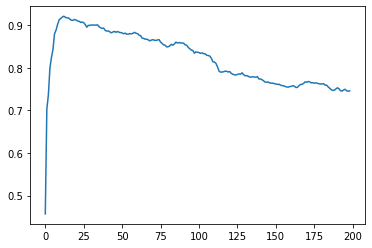

12





 90%|█████████ | 18/20 [3:25:18<24:14, 727.33s/it]

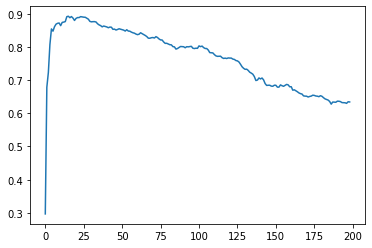

15





 95%|█████████▌| 19/20 [3:37:25<12:07, 727.44s/it]

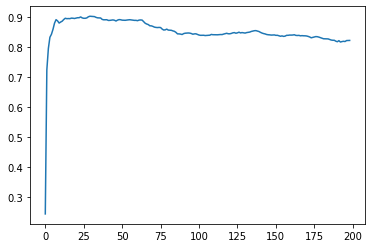

29





100%|██████████| 20/20 [3:49:30<00:00, 726.71s/it]




CPU times: user 5h 22min 27s, sys: 13min 57s, total: 5h 36min 25s
Wall time: 3h 49min 31s


In [0]:
%%time

mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

reward_his = []

n_games = 10
n_maps = 20
gamma = 0.5

epsilon = 0.1
epsilon_dec = 0.8

for __ in tqdm(range(n_maps)):
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train = X[train_indices]
  X_test = X[test_indices]
  Y_train = Y[train_indices]
  Y_test = Y[test_indices]
  accuracy_list = []
  for x in x_range:
    accuracy_list.append(calAccuracy(x))
  plt.plot(accuracy_list)
  plt.show()
  print(np.argmax(accuracy_list))

  for _ in range(n_games):
    # cur_state = init_state
    # cur_nor_state = init_nor_state
    for step_ctr in range(one_game_steps):
      
    # predict action
      epsilon *= epsilon_dec
      if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
        action = np.random.choice(step_options)
      else:
        # once random walk were done, the state in memory will be normalized

        indices = np.random.choice(len(state_mem), batch_size, replace=False)

        batch_states = np.array(list(state_mem.values()))[indices]
        batch_next_states = np.array(list(next_state_mem.values()))[indices]
        batch_actions = np.array(list(onehot_action_mem.values()))[indices]
        batch_rewards = np.array(list(reward_mem.values()))[indices]

        q_matrix = q_model.predict(batch_states)
        q_next = q_model.predict(batch_next_states)

        actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
        batch_indices = np.arange(batch_size, dtype=np.int64)

        q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


        q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

        action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
      
      next_state, reward = step(cur_state, action)
      next_nor_state = scaler_state.transform([next_state])[0]
      
      writeMem(cur_nor_state, next_nor_state, action, reward)
      reward_his.append(reward)

      cur_state = next_state
      cur_nor_state = next_nor_state

      mem_ctr += 1


q_model.save("./pickles/dql_diffmap_4_mem_model.h5")

## Test by Changing Test Set

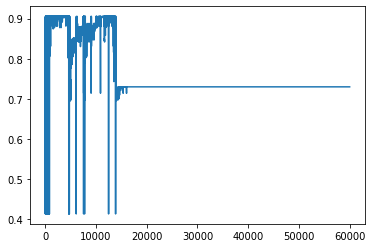

In [0]:
plt.plot(reward_his)

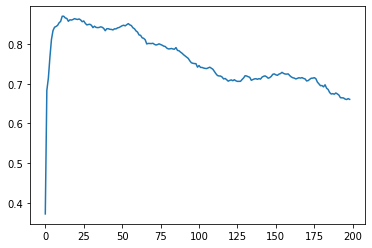

11


In [0]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracyTest(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))



  0%|          | 0/180 [00:00<?, ?it/s]

  1%|          | 1/180 [00:00<00:23,  7.54it/s]

  1%|          | 2/180 [00:00<00:23,  7.50it/s]

  2%|▏         | 3/180 [00:00<00:23,  7.39it/s]

  2%|▏         | 4/180 [00:00<00:24,  7.29it/s]

  3%|▎         | 5/180 [00:00<00:24,  7.11it/s]

  3%|▎         | 6/180 [00:00<00:25,  6.85it/s]

  4%|▍         | 7/180 [00:01<00:25,  6.71it/s]

  4%|▍         | 8/180 [00:01<00:25,  6.63it/s]

  5%|▌         | 9/180 [00:01<00:26,  6.47it/s]

  6%|▌         | 10/180 [00:01<00:26,  6.32it/s]

  6%|▌         | 11/180 [00:01<00:27,  6.11it/s]

  7%|▋         | 12/180 [00:01<00:27,  6.01it/s]

  7%|▋         | 13/180 [00:02<00:28,  5.80it/s]

  8%|▊         | 14/180 [00:02<00:29,  5.72it/s]

  8%|▊         | 15/180 [00:02<00:29,  5.62it/s]

  9%|▉         | 16/180 [00:02<00:29,  5.47it/s]

  9%|▉         | 17/180 [00:02<00:30,  5.32it/s]

 10%|█         | 18/180 [00:02<00:31,  5.21it/s]

 11%|█         | 19/180 [00:03<00:31,  5.10it/s]

 11%|█         |

[0.6614276823528578, 0.6625406035200994, 0.6606831237962987, 0, 0, 199]
[0.8461297418660597, 0.8457837203085837, 0.8487695033478881, 0.8513338888449575, 0.8464493828741391, 54]


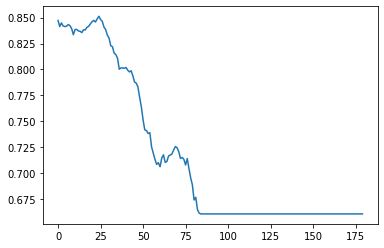

In [0]:
x = 30
detection = detectTest(detect_range, x)
cur_nor_state = scaler_state.transform([detection + [x]])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state
prediction = []
cur_state = init_state
max_state = cur_state
for step_ctr in tqdm(range(180)):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = stepTest(cur_state, action)
  if reward > max_state[3]:
    max_state = next_state
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
print(cur_state)
print(max_state)

## Test by Changing Test Set

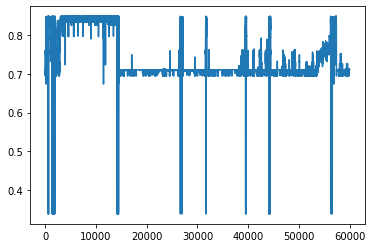

In [0]:
q_model = load_model("./pickles/dql_diffmap_4_mem_model.h5")

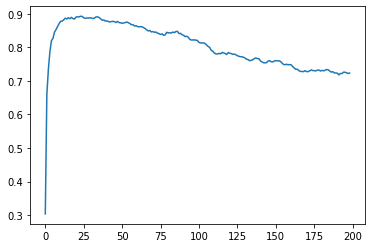

23


In [0]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracyTest(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

100%|██████████| 100/100 [00:04<00:00, 21.51it/s]


[0.7346417585874339, 0.819884718639603, 0.8267427104245976, 0.8457243381982612, 0.8620956344813175, 6]
[0.8904728259231961, 0.8911514939798127, 0.8928013609332612, 0.8922650362165239, 0.8865240492461266, 24]


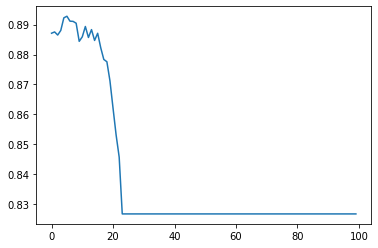

In [0]:
x = 30
detection = detectTest(detect_range, x)
cur_nor_state = scaler_state.transform([detection + [x]])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state
prediction = []
cur_state = init_state
max_state = cur_state
for step_ctr in tqdm(range(100)):
  action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
  next_state, reward = stepTest(cur_state, action)
  if reward > max_state[3]:
    max_state = next_state
  next_nor_state = scaler_state.transform([next_state])[0]
  prediction.append(reward)
  cur_state = next_state
  cur_nor_state = next_nor_state
plt.plot(prediction)
print(cur_state)
print(max_state)